## 4 Pre-training

### pre-traing 통해 accuracy 향상 방법 연구

- 다양한 버트를 적용해 보았으나 정확도(accuracy) 향상에 한계를 느끼게 되었고
- Language Model 을 kt 상담 언어(corpus)로 pre-training 하여 최적화된 모델(weights)을 만들게 되면 정확도가 향상될 수 있지 않을까 생각하게 되었습니다.


■ 학습 방법 :
* KcBert의 pre-training 전반적인 과정에 대한 이해 ([beomi님 블로그](https://beomi.github.io/2020/02/26/Train-BERT-from-scratch-on-colab-TPU-Tensorflow-ver/))
* 방법1) KcBert에서 공개한 학습데이터와 kt sci 상담 데이터를 합쳐서 language model 처음부터 학습 시키기 - 13GB로 용량이 크고 오랜 시간 걸려 비추천 
* 방법2) KcBert의 parameters를 그대로 차용하여 kt 상담 데이터로 language model을 re-training 해볼 것 - 대안으로 적절

<br><br>
#### (1) 라이브러리 임포트 및 gpu 환경세팅

In [1]:
import pandas as pd
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# GPU 사용 지정
if torch.cuda.is_available():    
    # PyTorch 에게 GPU를 사용하라고 지시합니다.    
    device = torch.device('cuda')
#     print('There are %d GPU(s) available.' % torch.cuda.device_count())
#     print('We will use the GPU:', torch.cuda.get_device_name(1))

# If not... CPU 사용 지정
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

<br><br>
#### (2) KcBert에서 공개한 학습 데이터와 kt sci 상담 데이터를 합친 후, Language Model을 처음부터 학습 시키기 

- KcBert에서 공개한 학습데이터 : [다운로드(11.62G)](https://www.kaggle.com/junbumlee/kcbert-pretraining-corpus-korean-news-comments)
- kt sci 3.5년치 학습 데이터 : data/augmented_train_data.tsv (87.5MB)

- 파이토치 기반 Language Model Pre-training 방법을 공유해 놓은 김준성님 깃허브 : [바로가기](https://github.com/codertimo/BERT-pytorch)

<br><br>
**1) Prepare your corpus - 아래 양식으로 데이터 형태 변환 (문장1 \t 문장2 \n)**

    > Welcome to the \t the jungle\n 
    > I can stay \t here all night\n

In [11]:
# 토크나이저 생성 
# 시간소요있음
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer(
    vocab_file=None,
    clean_text=True,
    handle_chinese_chars=True,
    strip_accents=False, # Must be False if cased model
    lowercase=False,
    wordpieces_prefix="##"
)

# ktkc_corpus : 11.6GB 의 kcbert 원본데이터 + kt sci 2선 데이터 (19만건) = 11.7GB
# 용량이 너무 커서 파일 미첨부
tokenizer.train(
    files=['../_bert_pretrain/_ktkc_corpus/ktkc_corpus'], # 11.7GB 로 공유폴더에 업로드 불가하기에 산출물로만 참고 부탁드립니다. 
    limit_alphabet=6000,
    vocab_size=32000
)


In [12]:
# 예시 ) 아래와 같이 word piece기반으로 토크나이징 
output = tokenizer.encode("메일 발송시 대상 서버에서 배달 알림을 보내지 않았습니다")
print(output.ids, output.tokens, output.offsets)

[2876, 6123, 24768, 6085, 14603, 24293, 10702, 13182, 3842, 6241, 6054, 27920, 11572, 10777] ['메', '##일', '발송', '##시', '대상', '서버', '##에서', '배달', '알', '##림', '##을', '보내지', '않았', '##습니다'] [(0, 1), (1, 2), (3, 5), (5, 6), (7, 9), (10, 12), (12, 14), (15, 17), (18, 19), (19, 20), (20, 21), (22, 25), (26, 28), (28, 31)]


In [26]:
# ktkc_corpus 파일 열기
## 용량이 너무 커서 파일 미첨부
with open('../_bert_pretrain/_ktkc_corpus/ktkc_corpus' , 'r') as f:
    ktkc_corpus = f.readlines()
    
# 토크나이저를 사용해 ktkc_corpus_wordpiece 파일 생성 
for line in ktkc_corpus:
    aa = line.split('\t')[0].strip()
    bb = line.split('\t')[1].strip().split('\n')[0]
    cc = ' '.join(tokenizer.encode(aa).tokens) + '\t' + ' '.join(tokenizer.encode(bb).tokens) +'\n' 
    with open('../_bert_pretrain/_ktkc_corpus/ktkc_corpus_wordpiece' , 'a') as f:
        f.write(cc)

<br><br>
**2) Building vocab based on your corpus**


In [27]:
# vocab 생성  : ktkc_vocab_wordpiece
!bert-vocab -c ktkc_corpus_wordpiece -o ktkc_vocab_wordpiece -s 32000

<br><br>
**3) Train your own BERT model**

- Language Model , pre-training

In [29]:
# 본격 pretraing (매우오랜시간소요)
!bert -c ktkc_corpus_wordpiece -v ktkc_vocab_wordpiece -o ktkc_1_model -e 30 -s 300 -b 16 -w 0 --lr 5e-5 --adam_weight_decay 0.00001 --on_memory False

* 문제 1 : 한 에포크에 100시간 이상이 걸리는 문제 발생 

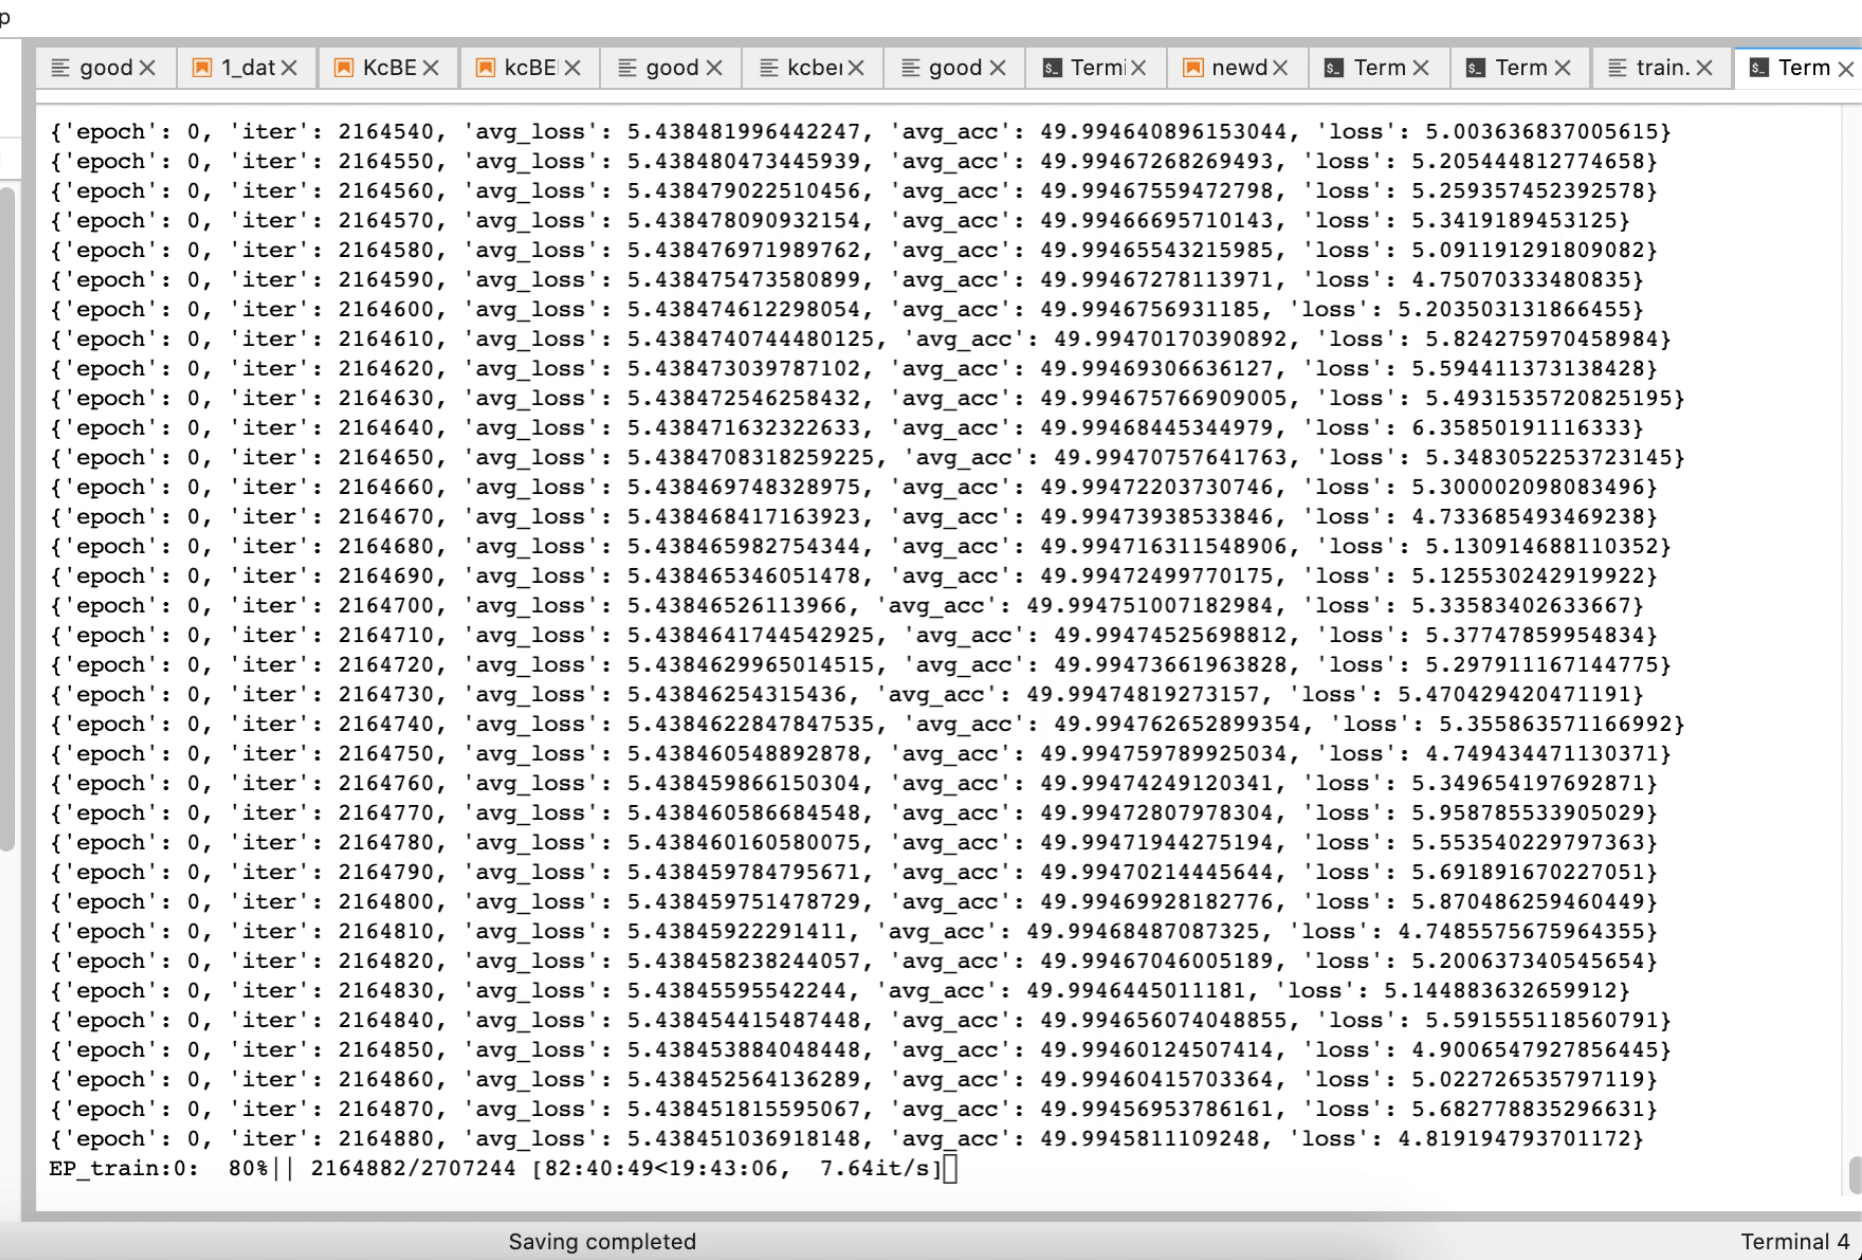

* 문제 2 : 메모리 이슈 등으로 잦은 실패

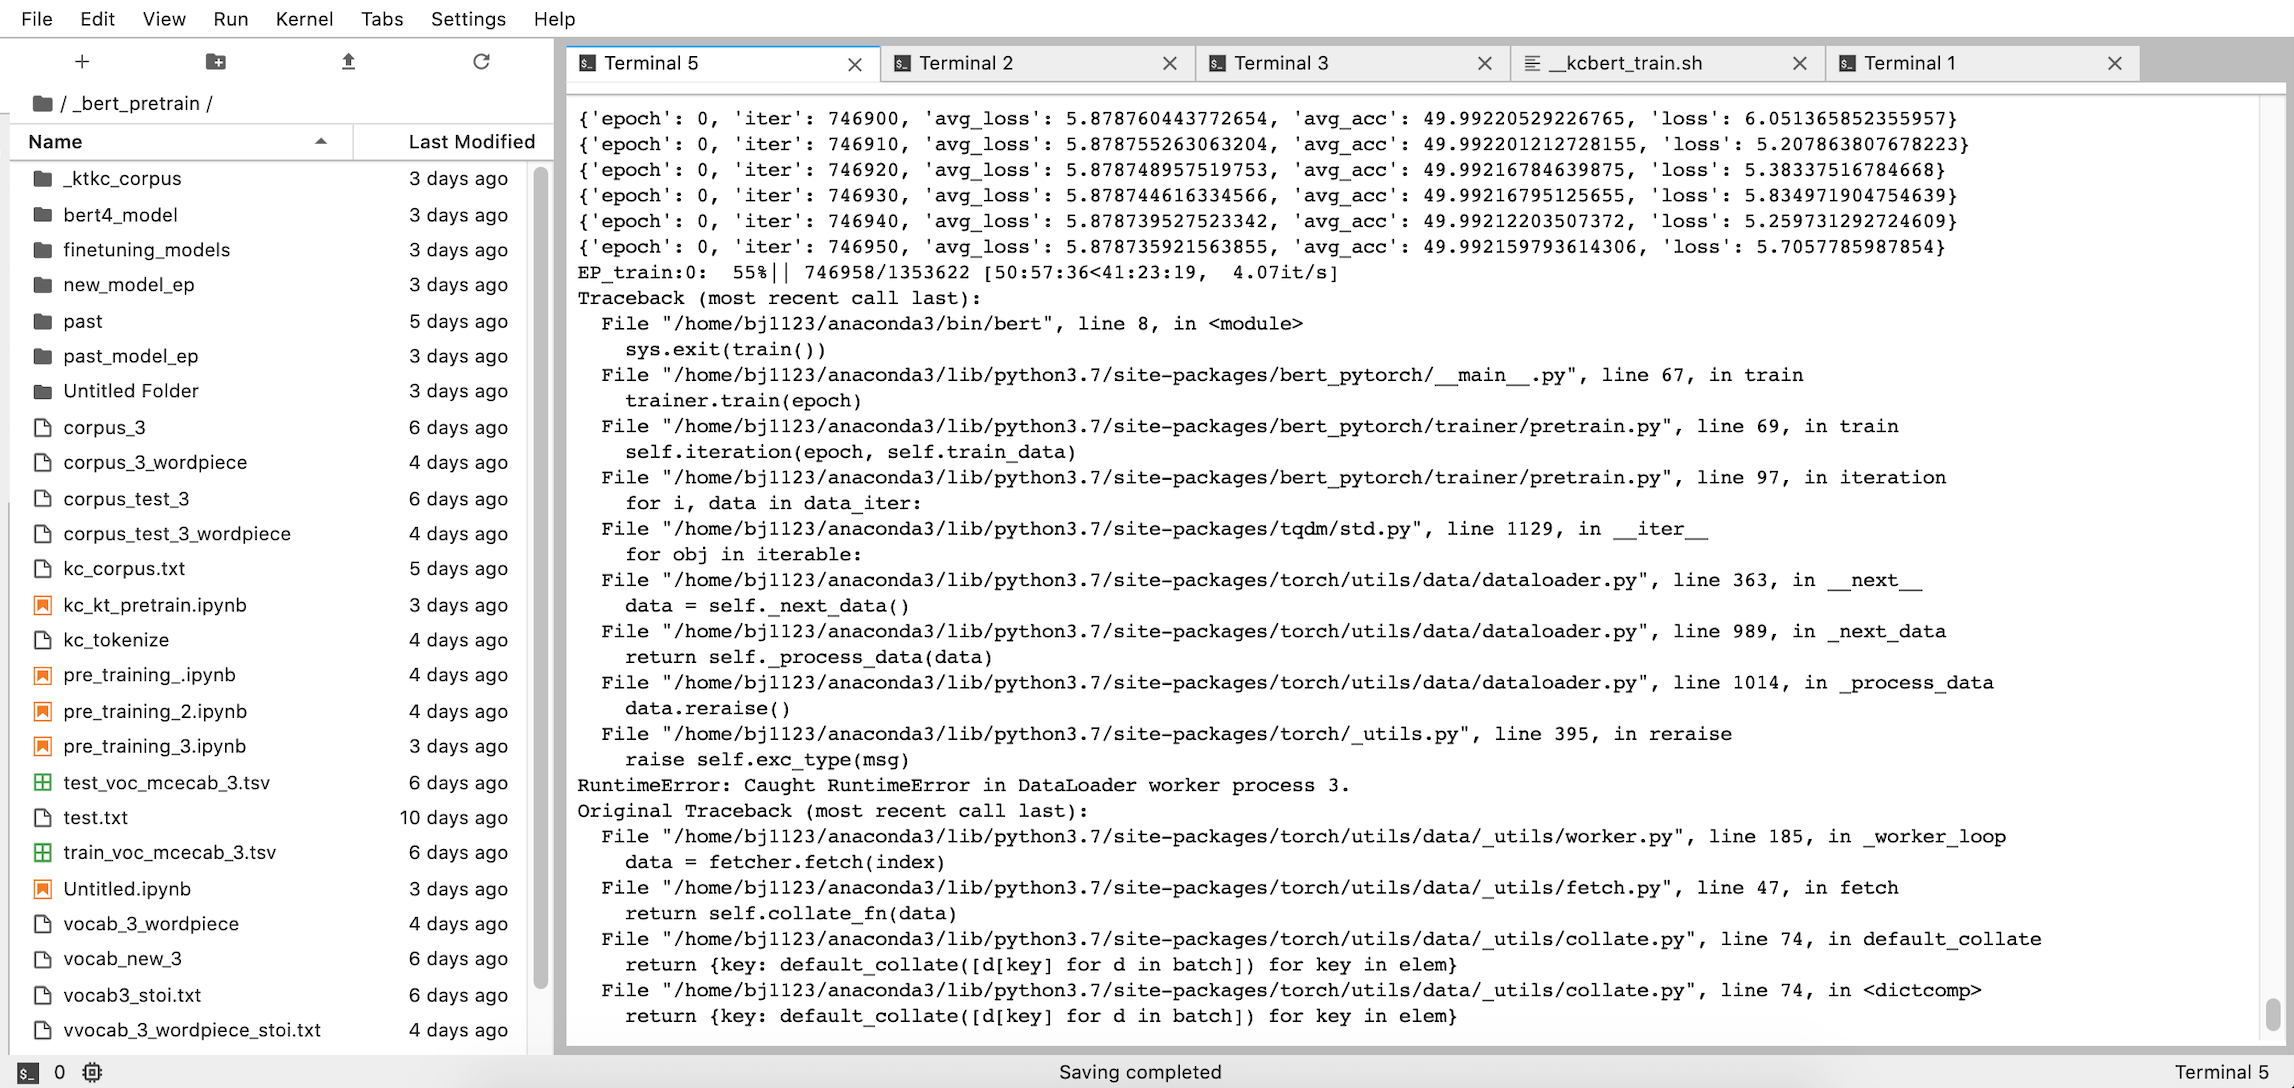

<br><br>
**4) fine-tuning**


In [16]:
from bert_pytorch import BERT
import torch.nn as nn

class BERTFINETUNE(nn.Module):
    def __init__(self, bert: BERT, num_class):
        super(BERTFINETUNE, self).__init__()
        self.bert = bert
        self.decode = nn.Linear(self.bert.hidden, num_class)
        nn.init.normal_(self.decode.weight,std=0.02)
        
    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        out = self.decode(x[:, 0])
        return out

In [33]:
from bert_pytorch import dataset
import torch

class Batchfier:
    def __init__(self, padding_idx = 0):
        self.tokenizer = tokenizer
        self.vocab = dataset.WordVocab.load_vocab('ktkc_vocab_wordpiece') # wordpiece 보캡
        self.padding_idx = padding_idx

    def batchfy(self, texts, labels=None):
        """
        :param texts: lists of texts
        :param labels: lists of indexed labels
        :return: indexed texts, masks, token_type_ids
        """
        def index_one(text):
            temp = ' '.join(self.tokenizer.encode(text).tokens) # wordpiece 형태로 토큰화 
            indexed = [self.vocab.sos_index] + self.vocab.to_seq(temp)
            return indexed[:300]  ## 
            
        indexed = [index_one(text) for text in texts]

        padded = self.pad_indexed(indexed)
        segment_label = torch.LongTensor([0]*padded.shape[1])

        if labels:
            return padded, segment_label, torch.LongTensor(labels)
        else:
            return padded, segment_label

    def pad_indexed(self, indexed):
        padded = [torch.LongTensor(text) for text in indexed] # tensor() 화
        padded = torch.nn.utils.rnn.pad_sequence(padded, batch_first=True, padding_value=self.padding_idx)
        return padded

In [18]:
from torch import nn
from tqdm import tqdm
import random
import apex


class Trainer:
    def __init__(self, model, optimizer, scheduler, batch_size=16 ): 
        self.model = model
        self.optimizer = optimizer
        self.batchfier = Batchfier()
        self.batch_size = batch_size
        self.cur_idx = 0
        self.criteria = nn.CrossEntropyLoss()
        self.scheduler = scheduler 
        
    # accuracy 산정
    def get_acc(self, logits, y):
        _, predicted = torch.max(logits.data, 1)
        total = y.size(0)
        correct = (predicted == y).sum().item()
        return correct, total

    # 배치사이즈 만큼 가져오기
    def get_batch(self, texts, labels):
        if self.cur_idx > len(texts):
            return None
        batch_texts = texts[self.cur_idx:self.cur_idx + self.batch_size]
        batch_labels = labels[self.cur_idx:self.cur_idx + self.batch_size]
        self.cur_idx += self.batch_size
        return self.batchfier.batchfy(batch_texts, batch_labels) #라벨은 이미 정수화 
    
    
    # train set 학습 버전
    def train_epochs(self, texts, labels ):
        self.cur_idx = 0
        self.model.train()
        self.model.zero_grad()
        pbar = tqdm()
        tot_loss = 0
        tot_correct = 0
        total_n = 0
        total_step = 0
        # 랜덤셔플적용 
        combine  = list(zip(texts,labels))
        random.shuffle(combine)
        texts,labels = zip(*combine)
        while True:
            res = self.get_batch(texts,labels)
            if not res:
                break
            x, segment_label, y = res
            x = x.to(device)
            y = y.to(device)
            segment_label = segment_label.to(device)
            logits = self.model(x, segment_label)
            loss = self.criteria(logits, y)
            correct, n = self.get_acc(logits,y)
            loss.backward() # apex 미적용버전
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0) 
            self.optimizer.step()
            self.scheduler.step() 
            self.model.zero_grad()
            tot_correct += correct
            total_n += n
            tot_loss+=loss
            total_step +=1
            pbar.set_description(
                "training loss : %f training acc : %f step : %f" % (
                    tot_loss / total_step, tot_correct / total_n, total_step) )
        pbar.close()
        with open(FILEPATH, "a") as f:
            f.write("training loss : %f training acc : %f step : %f \n" % (
                    tot_loss / total_step, tot_correct / total_n, total_step) )        

        
    # test set 학습 버전
    def test_epochs(self, texts, labels):
        self.cur_idx = 0
        self.model.eval()
        pbar = tqdm()
        tot_loss = 0
        tot_correct = 0
        total_n = 0
        total_step = 0
        while True:
            with torch.no_grad():
                res = self.get_batch(texts, labels)
                if not res:
                    break
                x, segment_label, y = res
                x = x.to(device)
                y = y.to(device)
                segment_label = segment_label.to(device)
                logits = self.model(x, segment_label)
                loss = self.criteria(logits, y)
                correct, n = self.get_acc(logits, y)
                tot_correct += correct
                total_n += n
                tot_loss += loss
                total_step += 1
                pbar.set_description(
                    "test loss : %f test acc : %f step : %f" % (
                        tot_loss / total_step, tot_correct / total_n, total_step))
        pbar.close()
        with open(FILEPATH, "a") as f:
            f.write("test loss : %f test acc : %f step : %f \n\n" % (
                        tot_loss / total_step, tot_correct / total_n, total_step) ) 

In [28]:
import torch
from transformers import  get_linear_schedule_with_warmup

epochs = 10 # 10
# MAX_LEN = 300 
BATCH_SIZE = 32 #  또는 16 

def get_model(lr,train_texts):
    bert = torch.load(MODEL)  
    model = BERTFINETUNE(bert,num_class=183).to(device)  
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps = 1e-8) 
    total_steps = len(train_texts)/BATCH_SIZE * epochs 
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 1000, 
                                            num_training_steps = total_steps) 
    return model, optimizer , scheduler

def main(train_texts, train_labels, test_texts, test_labels):
    for lrss in lrs:
        print('--------{}-----'.format(lrss))
        model, optimizer, scheduler = get_model(lr=lrss, train_texts=train_texts) 
        # 학습
        trainer = Trainer(model, optimizer, scheduler, batch_size=BATCH_SIZE)
        for i in range(epochs): 
            print('--------epodch {}-----'.format(i+1))
            with open(FILEPATH, "a") as f:
                f.write('--------epodch {} ----- lr {} --- model : {} \n'.format(i+1 , lrss , MODEL ))             
            trainer.train_epochs(train_texts, train_labels)
            trainer.test_epochs(test_texts, test_labels)    


In [48]:
# 4.5년치 train 데이터로 fine tuning
import pandas as pd
train = pd.read_table('data/augmented_train_data_mecab.tsv' ,sep = "\t" ,encoding='utf-8',header=0)
train.columns = ['label','text']
test = pd.read_table('data/test_data_mecab.tsv' ,sep = "\t" ,encoding='utf-8',header=0)
test.columns = ['label_t','text_t']
# train set
train_text = [line.strip() for line in train.text.tolist()]
train_label = train.label.tolist()
# label
lb_183 = sorted(test.label_t.unique()) #183
len(lb_183)
# test set
test_text = [line.strip().lower() for line in test.text_t.tolist()]
test_label = test.label_t.tolist()
# label to index 
word_idx = {j:i for i,j in enumerate(sorted(test.label_t.unique()))}  # {j:i for i,j in enumerate(set(label))}
train_label_idx = [word_idx[i] for i in train_label]
test_label_idx = [word_idx[i] for i in test_label]
len(train_text) , len(train_label_idx) , len(test_text)  , len(test_label_idx)
print('augmented train set 개수 :' ,len(train_text) )
print('test set 개수 :' ,len(test_text) )

augmented train set 개수 : 192761
test set 개수 : 8327


In [50]:
cd ../_bert_pretrain/_ktkc_corpus

/home/bj1123/_bert_pretrain/_ktkc_corpus


In [51]:
FILEPATH = '_ktkc_aug_ep0.txt' # 에포크별 학습 결과 저장

MODEL = 'ktkc_1_model.ep0' # epoch 1회 학습된 pretraining 모델을 가져옵니다. (100시간소요) 

lrs = [5e-4]

train_texts = train_text
train_labels = train_label_idx

test_texts = test_text
test_labels = test_label_idx

print(f'뉴모델 : {MODEL}  , 기록 : {FILEPATH} , lr : {lrs}')

main(train_texts, train_labels, test_texts, test_labels)

뉴모델 : ktkc_1_model.ep0  , 기록 : _ktkc_aug_ep0.txt , lr : [0.0005]
--------0.0005-----


0it [00:00, ?it/s]

--------epodch 1-----


training loss : 2.103126 training acc : 0.506041 step : 6024.000000: : 0it [14:02, ?it/s]
test loss : 1.522676 test acc : 0.660862 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 2-----


training loss : 1.087369 training acc : 0.706388 step : 6024.000000: : 0it [14:07, ?it/s]
test loss : 1.256941 test acc : 0.707938 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 3-----


training loss : 0.930403 training acc : 0.743579 step : 6024.000000: : 0it [14:15, ?it/s]
test loss : 1.099431 test acc : 0.735439 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 4-----


training loss : 0.834168 training acc : 0.766530 step : 6024.000000: : 0it [14:10, ?it/s]
test loss : 0.984684 test acc : 0.753453 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 5-----


training loss : 0.766786 training acc : 0.781413 step : 6024.000000: : 0it [13:56, ?it/s]
test loss : 0.969873 test acc : 0.759938 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 6-----


training loss : 0.710926 training acc : 0.794460 step : 6024.000000: : 0it [14:03, ?it/s]
test loss : 0.951915 test acc : 0.767864 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 7-----


training loss : 0.661754 training acc : 0.806071 step : 6024.000000: : 0it [13:47, ?it/s]
test loss : 0.891015 test acc : 0.773508 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 8-----


training loss : 0.613330 training acc : 0.818278 step : 6024.000000: : 0it [14:12, ?it/s]
test loss : 0.905402 test acc : 0.769905 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 9-----


training loss : 0.569983 training acc : 0.828223 step : 6024.000000: : 0it [14:17, ?it/s]
test loss : 0.899216 test acc : 0.775670 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 10-----


training loss : 0.532214 training acc : 0.838250 step : 6024.000000: : 0it [14:08, ?it/s]
test loss : 0.896114 test acc : 0.775670 step : 261.000000: : 0it [00:11, ?it/s]


In [52]:
FILEPATH = '_ktkc_aug_ep1.txt'
MODEL = 'ktkc_1_model.ep1' # epoch 2회 학습된 pretraining 모델을 가져옵니다.  (200시간소요) 

lrs = [5e-4]

train_texts = train_text
train_labels = train_label_idx

test_texts = test_text
test_labels = test_label_idx

print(f'뉴모델 : {MODEL}  , 기록 : {FILEPATH} , lr : {lrs}')

main(train_texts, train_labels, test_texts, test_labels)

뉴모델 : ktkc_1_model.ep1  , 기록 : _ktkc_aug_ep1.txt , lr : [0.0005]
--------0.0005-----


0it [00:00, ?it/s]

--------epodch 1-----


training loss : 2.210619 training acc : 0.490250 step : 6024.000000: : 0it [14:10, ?it/s]
test loss : 1.621168 test acc : 0.656419 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 2-----


training loss : 1.125066 training acc : 0.697169 step : 6024.000000: : 0it [13:58, ?it/s]
test loss : 1.285432 test acc : 0.706497 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 3-----


training loss : 0.953905 training acc : 0.738111 step : 6024.000000: : 0it [14:03, ?it/s]
test loss : 1.097318 test acc : 0.730635 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 4-----


training loss : 0.857678 training acc : 0.760719 step : 6024.000000: : 0it [14:01, ?it/s]
test loss : 1.054637 test acc : 0.741684 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 5-----


training loss : 0.789251 training acc : 0.776013 step : 6024.000000: : 0it [14:16, ?it/s]
test loss : 1.006446 test acc : 0.754533 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 6-----


training loss : 0.734330 training acc : 0.789605 step : 6024.000000: : 0it [13:37, ?it/s]
test loss : 1.011978 test acc : 0.762940 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 7-----


training loss : 0.683121 training acc : 0.801895 step : 6024.000000: : 0it [13:55, ?it/s]
test loss : 0.979826 test acc : 0.761619 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 8-----


training loss : 0.635056 training acc : 0.813723 step : 6024.000000: : 0it [13:58, ?it/s]
test loss : 0.914622 test acc : 0.769545 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 9-----


training loss : 0.593541 training acc : 0.822900 step : 6024.000000: : 0it [14:01, ?it/s]
test loss : 0.929948 test acc : 0.771106 step : 261.000000: : 0it [00:11, ?it/s]
0it [00:00, ?it/s]

--------epodch 10-----


training loss : 0.556235 training acc : 0.832601 step : 6024.000000: : 0it [14:00, ?it/s]
test loss : 0.908854 test acc : 0.776870 step : 261.000000: : 0it [00:11, ?it/s]


> epoch 0 일때 test acc 가 0.775에서 -> epoch 1에서는 0.776로 상승 \
> 시간과 자원이 있다면 epoch 30 까지 pre training 했을 시, 상승하는 accuracy를 기대할 수 있으나 \
> 자원과 시간의 한계로 epoch 2번째에서 마무리 하고 \
> 다른 방법을 찾게 되었습니다.

<br><br>
#### (3) KcBert의 pretrained LM 위에서 kt 상담 데이터로 language model을 re-training 하는 방법 연구

- **아이디어 : pretrained 된 KcBert 의 language model parameters 위에 추가로 kt corpus로 재학습(re-training)** 
- 다량의 구어체로 학습이 된 잘 만들어진 KcBert를 충분히 활용하자는 취지며, kt 상담 언어를 추가하여 pretraining 할 경우 kt 도메인에 좀 더 최적화된 language model을 만들 수 있을 것으로 생각하였습니다.
- 기대효과 : 처음부터 오랜 시간과 많은 자원을 투여하지 않고, 적은 시간과 자원으로 좋은 성능을 기대해 볼 수 있을 것입니다.

<br><br>
**1) Pre-training 시행**
- 자세한 코드 설명은 생략하며 깃허브 사례를 참고하여 customed 화 진행 하였습니다. 
- [깃허브 참고](https://gitlab.spacecode.sk/tuke-kkui-zhu/deep-complete/ml/-/blob/d240866e32527b1a25437ede11e1076ec1d03233/_transformers/run_language_modeling.py)
- <code>pre-train 시행 후 최종 모델 경로 : /pre_training/method_2/models/pytorch_model.bin </code>

In [ ]:
cd pre_training/method_2

In [ ]:
!python temp.py \
    --model_name_or_path  beomi/kcbert-base \
    --train_data_file ../../data/augmented_train_data_mecab.tsv \
    --do_train \
    --learning_rate 5e-5 \
    --num_train_epochs 30 \
    --save_total_limit 3 \
    --save_steps 2000 \
    --per_device_train_batch_size 32 \
    --seed 42 \
    --block_size 300 \
    --output_dir ./models \
    --mlm \
    --tokenizer_name beomi/kcbert-base;

2020-10-06 16:08:38.028594: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
10/06/2020 16:08:39 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
10/06/2020 16:08:39 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir='./models/ktBERT-base', overwrite_output_dir=False, do_train=True, do_eval=False, do_predict=False, evaluate_during_training=False, prediction_loss_only=False, per_device_train_batch_size=32, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=30.0, max_steps=-1, warmup_steps=0, logging_dir='runs/Oct06_16-08-39_digits', logging_first_step=False, logging_steps=500, save_steps=2000, save_total_limit=3, no_cuda

> 30 에포크까지 약 2-3일 소요 \
> 많은 실험을 통해 발견한 하이퍼파리미터로 최종 language model 저장

<br><br>
**2) fine-tuning 시행**

- pre-trained LM 모델(pytorch_model.bin) 을 불러와 기존 kcbert의 구조체에 새로 학습된 kt 모델(weights)를 load 합니다.
- 19만 건의 train data(기간 4.5년=3.5년+11개월) 를 사용하여 fine tuning 시행하였습니다.

In [ ]:
cd pre_training/

In [17]:
!python finetune_ktbert.py \
    --pretrained_model_name beomi/kcbert-base \
    --model_lm_fn method_2/models/pytorch_model.bin \
    --model_fn method_2/_params/ktbert_mecab_last_ver.pth \
    --txt_fn method_2/_params/ktbert_mecab_last_ver.txt \
    --train_fn ../data/augmented_train_data_mecab.tsv \
    --test_fn ../data/test_data_mecab.tsv \
    --gpu_id 0 \
    --batch_size 32 \
    --max_length 300 \
    --lr 5e-5 \
    --warmup_ratio 0 \
    --n_epochs 5

========= config ========= 
|config| : Namespace(adam_epsilon=1e-08, batch_size=32, gpu_id=0, lr=5e-05, max_length=300, model_fn='method_2/_params/ktbert_mecab_last_ver.pth', model_lm_fn='method_2/models/model/pytorch_model.bin', n_epochs=5, pretrained_model_name='beomi/kcbert-base', test_fn='../data/test_data_mecab.tsv', train_fn='../data/augmented_train_data_mecab.tsv', txt_fn='method_2/_params/ktbert_mecab_last_ver.txt', verbose=2, warmup_ratio=0.0) 
 ========= learning rate 5e-05 ========= 
 |pretrained_model_name| : beomi/kcbert-base 
 |model_fn| : method_2/_params/ktbert_mecab_last_ver.pth 
 |batch_size| : 32 
 |max_length| : 300 
 |warmup_ratio| : 0.0 
 |adam_epsilon| : 1e-08 
 |model_lm_fn| : method_2/models/model/pytorch_model.bin 
 
Epoch 1 - |param|=3.22e+02 |g_param|=6.12e+00 loss=6.6949e-01 accuracy=0.8118
Valid - loss=7.4059e-01 accuracy=0.7983 best_loss=inf best_acc=0.0000
Test - |accuracy| : 0.7956

Epoch 2 - |param|=3.22e+02 |g_param|=6.24e+00 loss=5.1632e-01 accuracy=

<br><br>
**3) test data 를 통한 accuracy 최종 체크**


In [19]:
!python _test.py \
    --model_load method_2/_params/ktbert_mecab_last_ver.pth  \
    --test_fn ../data/test_data_mecab.tsv \
    --gpu_id 0 \
    --batch_size 64

2020-10-07 13:05:44.248918: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

In [22]:
!_test_confusion.py

Test set: 8327
Test labels: 183


Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali


|accuracy| : 0.8239


       ============ Confusion Matrix ============ 

              precision    recall  f1-score   support

    ASM14261       0.00      0.00      0.00         1
    ASM14262       0.00      0.00      0.00         1
    ASM14263       0.93      0.95      0.94        41
    ASM14284       0.74      0.83      0.78        30
    ASM14307       0.00      0.00      0.00         1
    ASM14324       1.00      0.80      0.89         5
    ASM14326       0.33      0.48      0.40        33
    ASM14334       1.00      1.00      1.00         1
    ASM14351       0.97      1.00      0.98        30
    ASM14352       0.90      0.75      0.82        12
    ASM14361       0.00      0.00      0.00         2
    ASM14362       0.83      1.00      0.91         5
    ASM14370       1.00      0.57      0.73        14
    ASM14382       0.80      1.00      0.89         8
    ASM14384       0.87      1.00      0.93        20
    ASM14385       0.88      0.98      0.93        47
    AS

<br><br>
#### (3) lessons learned

- Bert의 pre-training 전반적인 이해를 할수있었습니다.
- kcbert 에서 공개한 구어체 13GB corpus와 kt 상담데이터를 합쳐서 처음부터 pretraining을 하고자하니 메모리 이슈와 시간적 소요(100시간/1에포크)가 있어 어려움을 느꼈습니다.
- 이 문제를 극복하기 위해, 아이디어를 낸 것은 기존 충분한 자원으로 잘 만들어진 kcbert의 Language model을 이용하자는 것이었고, 여기에 추가로 kt 상담 data를 더해 pretraining 을 해본다면 좋은 성과가 날것이란 기대로 시작하였고 결과는 다행히 82.39% 의 accuracy를 산출할 수 있었습니다.
- 범용적인 버트를 사용하는 것은 일정 이상의 분류 정확도를 확보할 수 있겠지만, 각각의 도메인에 최적화된 결과를 위해서는 도메인 corpus기반의 language model을 재학습 시키는 방법도 시도해봐야하는 작업임을 알게되었습니다.


<br><br><br><br><br><br><br>
<hr>

작성자 : 박은진